# Kaggle Api

In [ ]:
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))
  
# Then move kaggle.json into the folder where the API expects to find it.
!mkdir -p ~/.kaggle/ && mv kaggle.json ~/.kaggle/ && chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json
User uploaded file "kaggle.json" with length 63 bytes


In [ ]:
!kaggle competitions download -c digit-recognizer

  0% 0.00/6.09M [00:00<?, ?B/s]
100% 6.09M/6.09M [00:00<00:00, 56.1MB/s]
  0% 0.00/235k [00:00<?, ?B/s]
100% 235k/235k [00:00<00:00, 74.6MB/s]
  0% 0.00/9.16M [00:00<?, ?B/s]
100% 9.16M/9.16M [00:00<00:00, 84.1MB/s]


In [ ]:
!unzip train.csv.zip

Archive:  train.csv.zip
  inflating: train.csv               


In [ ]:
!unzip test.csv.zip

Archive:  test.csv.zip
  inflating: test.csv                


# Modules

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
import tensorflow as tf
import sklearn.preprocessing as preprocessor
from tensorflow.keras.optimizers import Adam
import sklearn.metrics as metrics
import itertools
from tensorflow.keras.datasets import mnist
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint
import math
from tensorflow.keras import Model
from sklearn.metrics.pairwise import cosine_similarity

# Utils

In [ ]:
plt.style.use('seaborn-white')

In [ ]:
def plot_100_images(imgs: np.array, label:np.array = None):
  rand_index = random.sample(range(imgs.shape[0]), 100)
  plt.figure(figsize=(40,40))
  for _,i in enumerate(rand_index):
    plt.subplot(10, 10, _+1)
    plt.imshow(imgs[i])
    if label is not None:
      plt.title(f'{i},label:{label[i]}')

In [ ]:
def standardize(img):
  mean = img.mean()
  std = img.std()
  return (img - mean) / std

In [ ]:
def normalize(img):
  return img/255.

In [ ]:
def regularizer(weights_decay=5e-4):
  return tf.keras.regularizers.l2(weights_decay)

In [ ]:
class ArcMarginPenaltyLogists(tf.keras.layers.Layer):
  def __init__(self, num_classes, margin=0.5, logist_scale=64, **kwargs):
    super(ArcMarginPenaltyLogists, self).__init__(**kwargs)
    self.num_classes = num_classes
    self.margin = margin
    self.logist_scale = logist_scale

  def build(self, input_shape):
    self.w = self.add_variable('weights',
                               shape=[int(input_shape[-1]), self.num_classes])
    self.cos_margin = tf.identity(math.cos(self.margin), name='cos_margin')
    self.sin_margin = tf.identity(math.sin(self.margin), name='sin_margin')
    self.th = tf.identity(math.cos(math.pi - self.margin), name='th')
    self.mm = tf.multiply(self.sin_margin, self.margin, name='mm')

  def call(self, embeddings, labels):
    normalize_embeddings = tf.nn.l2_normalize(embeddings, axis=1, name='normalize_embeddings')
    normalize_weights= tf.nn.l2_normalize(self.w, axis=0, name='normalize_weights')
    cos_theta = tf.matmul(normalize_embeddings, normalize_weights, name='cos_theta')
    sin_theta = tf.sqrt(1.-cos_theta**2, name='sin_theta')
    cos_mt = tf.subtract(cos_theta*self.cos_margin,
                          sin_theta*self.sin_margin,
                          name='cos_mt')
    cos_mt = tf.where(cos_theta > self.th, cos_mt, cos_theta - self.mm)
    mask = tf.one_hot(tf.cast(labels, tf.int32), depth=self.num_classes,
                          name='one_hot_mask')
    logists = tf.where(mask==1., cos_mt, cos_theta)
    # logists = tf.where(labels==1., cos_mt, cos_theta)
    logist = tf.multiply(logists, self.logist_scale, name='arcface_logis')
    return logist

In [ ]:
def backbone(embedding_shape, weights_decay):
  def simple_net(x_input):
    x = inputs = tf.keras.layers.Input(x_input.shape[1:])
    x = tf.keras.layers.Conv2D(16, (3, 3), padding='SAME')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation('relu')(x)
    x = tf.keras.layers.MaxPooling2D()(x)
    x = tf.keras.layers.Conv2D(32, (3, 3), padding='SAME')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation('relu')(x)
    x = tf.keras.layers.MaxPooling2D()(x)
    x = tf.keras.layers.Conv2D(64, (3, 3), padding='SAME')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation('relu')(x)
    x = tf.keras.layers.MaxPooling2D()(x)
    x = tf.keras.layers.Conv2D(128, (3, 3), padding='SAME')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation('relu')(x)
    x = tf.keras.layers.MaxPooling2D()(x)
    x = tf.keras.layers.Conv2D(256, (5, 5), padding='SAME')(x)
    x = tf.keras.layers.Flatten()(x)
    x = tf.keras.layers.Dense(embedding_shape, kernel_regularizer=regularizer(weights_decay), activation='relu')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    return Model(inputs, x)(x_input)
  return simple_net

In [ ]:
def ArcHead(num_classes, margin=0.5, logist_scale=64, name='ArcHead'):
  def arc_head(x_input, y_input):
    x = inputs = tf.keras.layers.Input(x_input.shape[1:])
    y = tf.keras.layers.Input(y_input.shape[1:])
    x = ArcMarginPenaltyLogists(num_classes=num_classes,
                                margin=margin,
                                logist_scale= logist_scale)(x, y)
    return Model((inputs, y), x)((x_input, y_input))
  return arc_head
                      

In [ ]:
def ArcModel(input_size, num_classes, embedding_shape, margin=0.5, logist_scale=64,
            weight_decay=5e-7):
  x = inputs = tf.keras.layers.Input(input_size, name='input_image')
  labels = tf.keras.layers.Input([], name='label')
  embeddings = backbone(embedding_shape, weight_decay)(x)
  logist = ArcHead(num_classes, margin, logist_scale)(embeddings, labels)
  return Model((inputs, labels), logist)

In [ ]:
def SoftmaxLoss():
    def softmax_loss(y_true, y_pred):
        y_true = tf.cast(tf.reshape(y_true, [-1]), tf.int32)
        ce = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y_true,
                                                            logits=y_pred)
        return tf.reduce_mean(ce)
    return softmax_loss

In [ ]:
def display_errors(imgs, labels, true_labels):
  pass

In [ ]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
  
    plt.figure(figsize=(7, 7))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [ ]:
def plot_distribution(label):
  count = Counter(label).items()
  count = sorted(count, key=lambda x: x[0])
  plt.bar(range(10), list(map(lambda x: x[1], count)))
  for x, y in count:
    plt.text(x, y + 0.05, f'{y}', ha='center', va= 'bottom')
  plt.xticks(range(10), range(10))

In [ ]:
def classifer_arc(input_size, num_classes, pretrained):
  model = ArcModel(input_size=input_size,
                   num_classes=num_classes,
                   embedding_shape=512)
  model.load_weights(pretrained)

  new_model = tf.keras.Sequential()
  new_model.add(model.layers[0])
  new_model.add(model.layers[1])
  return new_model

# Change Pandas into Numpy array

## Train

In [ ]:
train = pd.read_csv('train.csv')

In [ ]:
train.describe

<bound method NDFrame.describe of        label  pixel0  pixel1  pixel2  ...  pixel780  pixel781  pixel782  pixel783
0          1       0       0       0  ...         0         0         0         0
1          0       0       0       0  ...         0         0         0         0
2          1       0       0       0  ...         0         0         0         0
3          4       0       0       0  ...         0         0         0         0
4          0       0       0       0  ...         0         0         0         0
...      ...     ...     ...     ...  ...       ...       ...       ...       ...
41995      0       0       0       0  ...         0         0         0         0
41996      1       0       0       0  ...         0         0         0         0
41997      7       0       0       0  ...         0         0         0         0
41998      6       0       0       0  ...         0         0         0         0
41999      9       0       0       0  ...         0         0   

In [ ]:
train

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,pixel10,pixel11,pixel12,pixel13,pixel14,pixel15,pixel16,pixel17,pixel18,pixel19,pixel20,pixel21,pixel22,pixel23,pixel24,pixel25,pixel26,pixel27,pixel28,pixel29,pixel30,pixel31,pixel32,pixel33,pixel34,pixel35,pixel36,pixel37,pixel38,...,pixel744,pixel745,pixel746,pixel747,pixel748,pixel749,pixel750,pixel751,pixel752,pixel753,pixel754,pixel755,pixel756,pixel757,pixel758,pixel759,pixel760,pixel761,pixel762,pixel763,pixel764,pixel765,pixel766,pixel767,pixel768,pixel769,pixel770,pixel771,pixel772,pixel773,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41995,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
41996,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
41997,7,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
41998,6,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [ ]:
label = np.array(train['label'])
label

array([1, 0, 1, ..., 7, 6, 9])

In [ ]:
X = train.drop(['label'], axis=1)
X

,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,pixel10,pixel11,pixel12,pixel13,pixel14,pixel15,pixel16,pixel17,pixel18,pixel19,pixel20,pixel21,pixel22,pixel23,pixel24,pixel25,pixel26,pixel27,pixel28,pixel29,pixel30,pixel31,pixel32,pixel33,pixel34,pixel35,pixel36,pixel37,pixel38,pixel39,...,pixel744,pixel745,pixel746,pixel747,pixel748,pixel749,pixel750,pixel751,pixel752,pixel753,pixel754,pixel755,pixel756,pixel757,pixel758,pixel759,pixel760,pixel761,pixel762,pixel763,pixel764,pixel765,pixel766,pixel767,pixel768,pixel769,pixel770,pixel771,pixel772,pixel773,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41995,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
41996,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
41997,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
41998,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [ ]:
X = X.values

In [ ]:
X.shape

(42000, 784)

In [ ]:
X = X.reshape(42000, 28, 28, 1)
X.shape

(42000, 28, 28, 1)

In [ ]:
X = np.concatenate((X, X, X), axis=-1)
X.shape

(42000, 28, 28, 3)

In [ ]:
X[0].shape

(28, 28, 3)

## Test

In [ ]:
X_test = pd.read_csv('test.csv')
X_test.head(10)

,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,pixel10,pixel11,pixel12,pixel13,pixel14,pixel15,pixel16,pixel17,pixel18,pixel19,pixel20,pixel21,pixel22,pixel23,pixel24,pixel25,pixel26,pixel27,pixel28,pixel29,pixel30,pixel31,pixel32,pixel33,pixel34,pixel35,pixel36,pixel37,pixel38,pixel39,...,pixel744,pixel745,pixel746,pixel747,pixel748,pixel749,pixel750,pixel751,pixel752,pixel753,pixel754,pixel755,pixel756,pixel757,pixel758,pixel759,pixel760,pixel761,pixel762,pixel763,pixel764,pixel765,pixel766,pixel767,pixel768,pixel769,pixel770,pixel771,pixel772,pixel773,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
6,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
7,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
8,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
9,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [ ]:
X_test = X_test.values
X_test.shape

(28000, 784)

In [ ]:
X_test = X_test.reshape(28000, 28, 28, 1)

In [ ]:
X_test = np.concatenate((X_test, X_test, X_test), axis=-1)
X_test.shape

(28000, 28, 28, 3)

# Explore Data

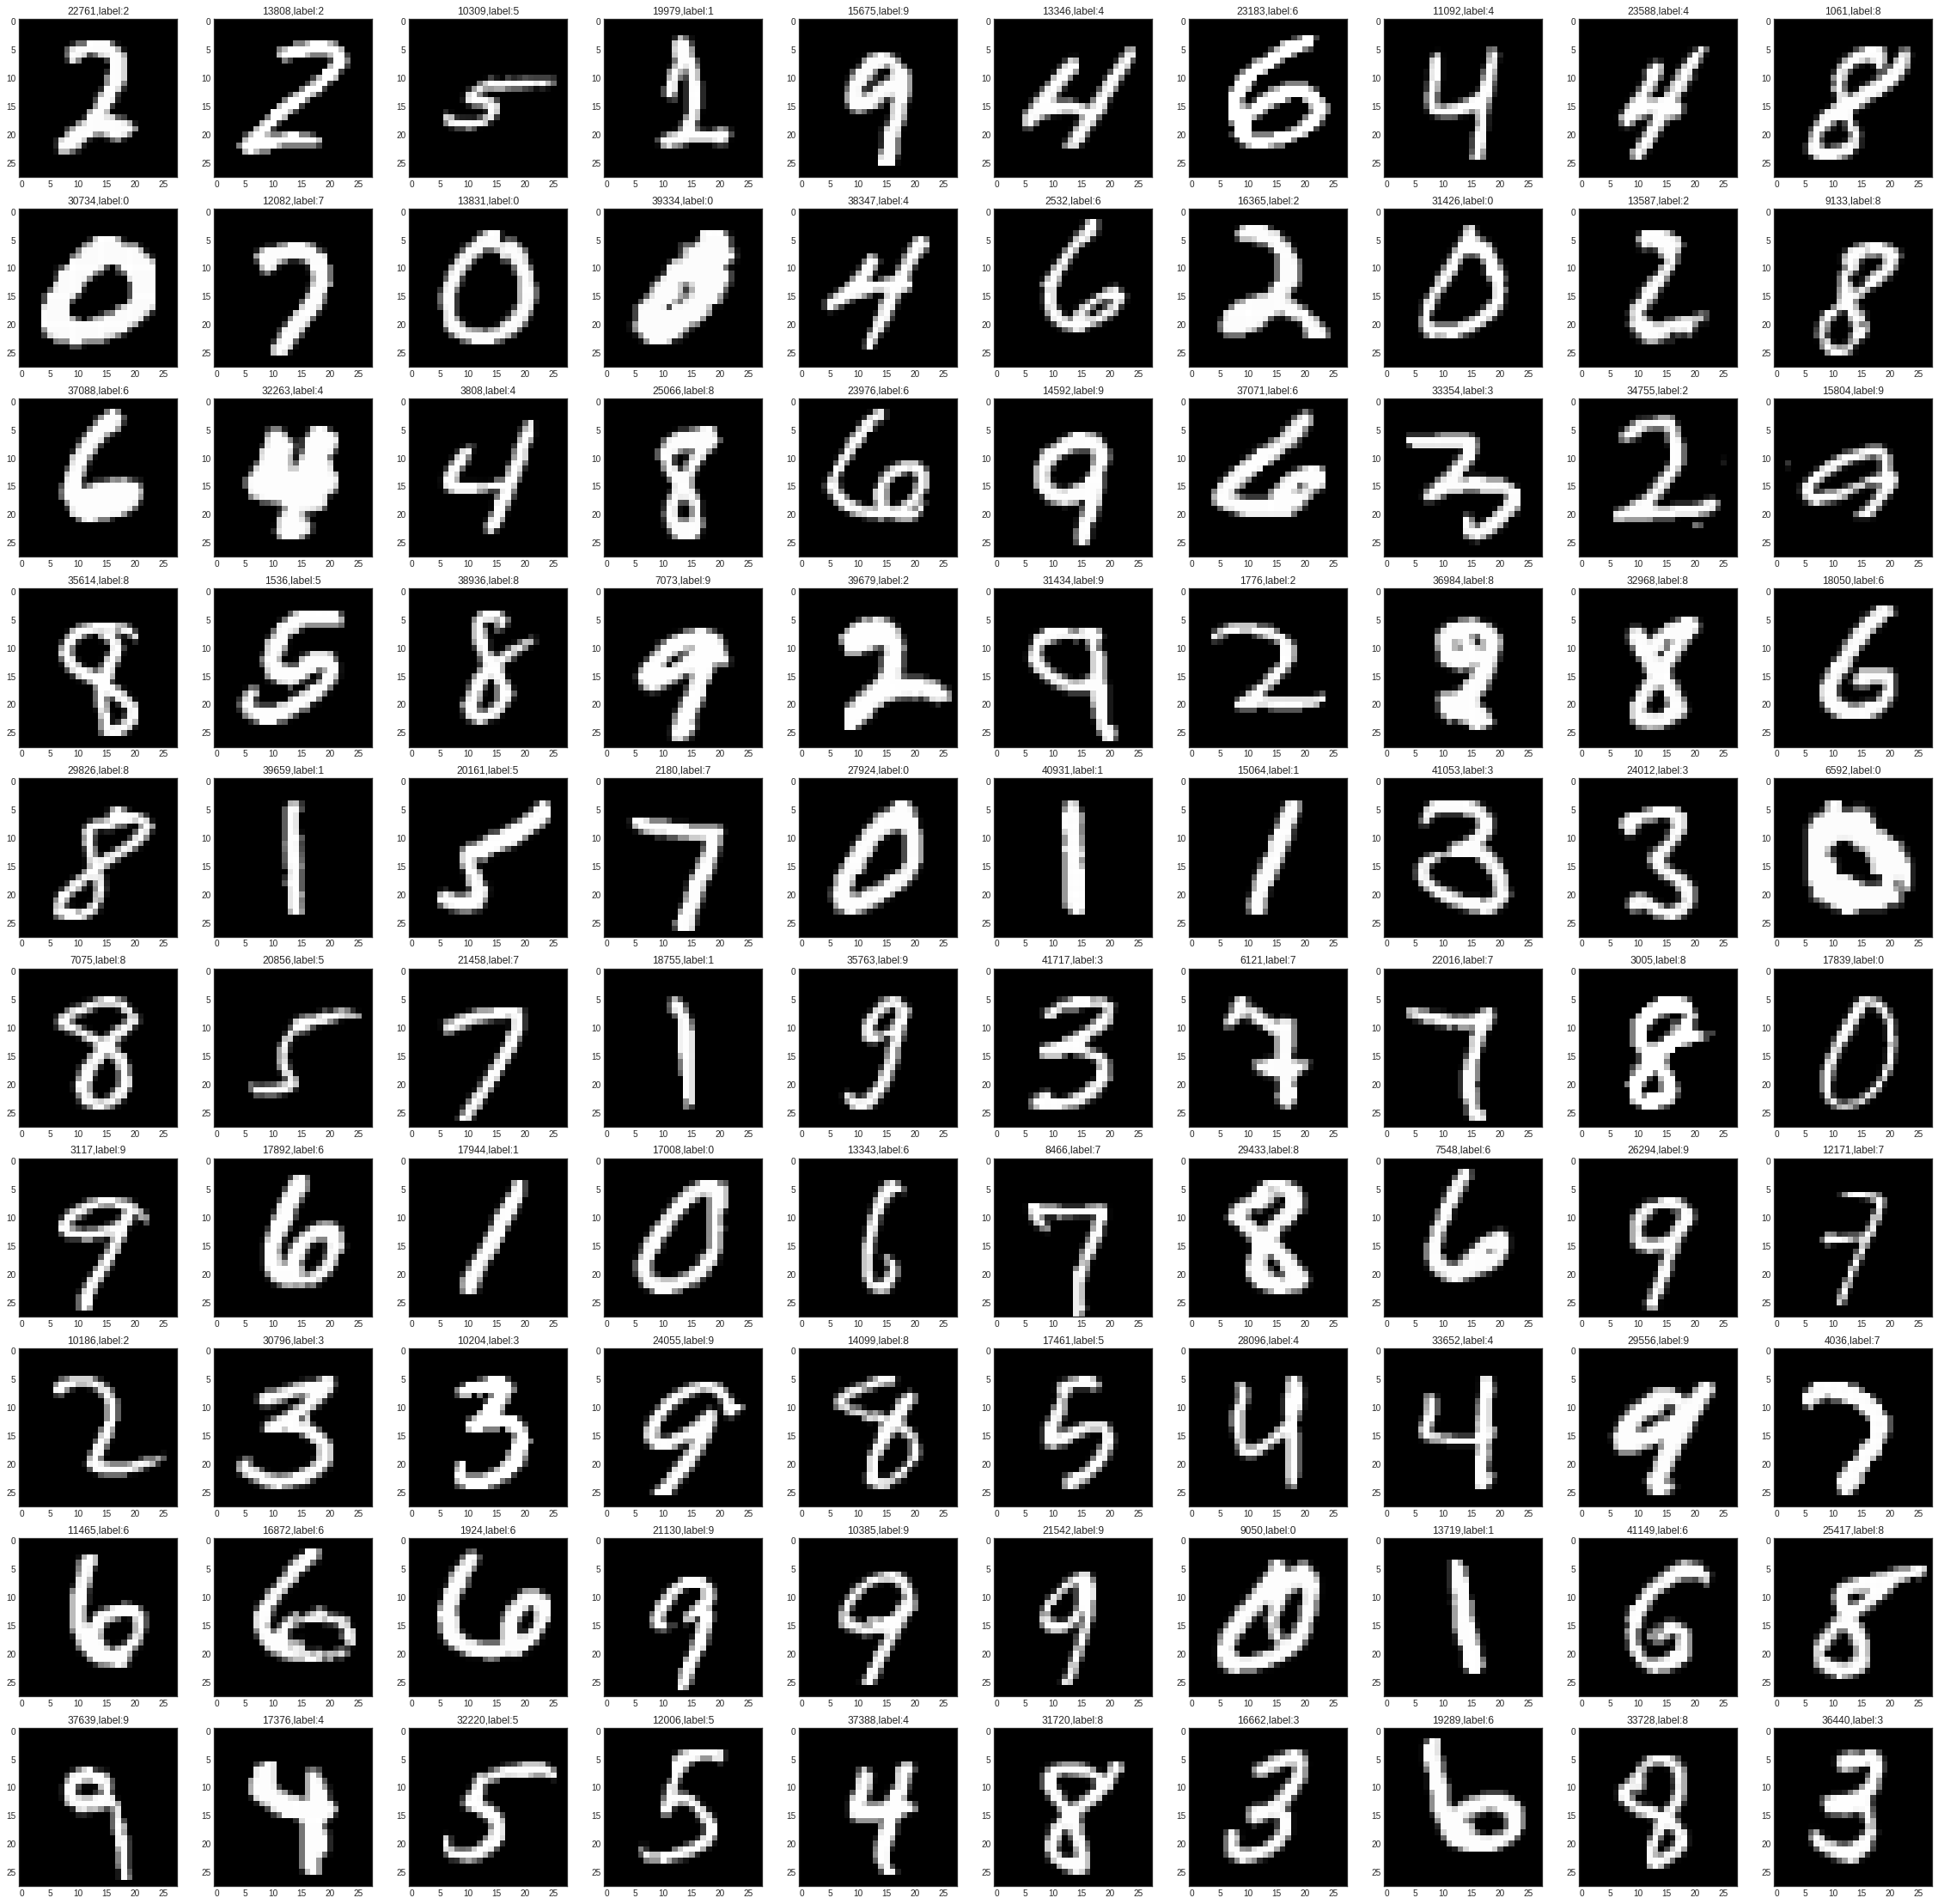

In [ ]:
plot_100_images(X, label)

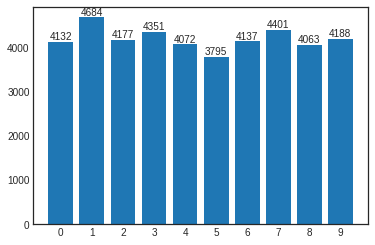

In [ ]:
plot_distribution(label)

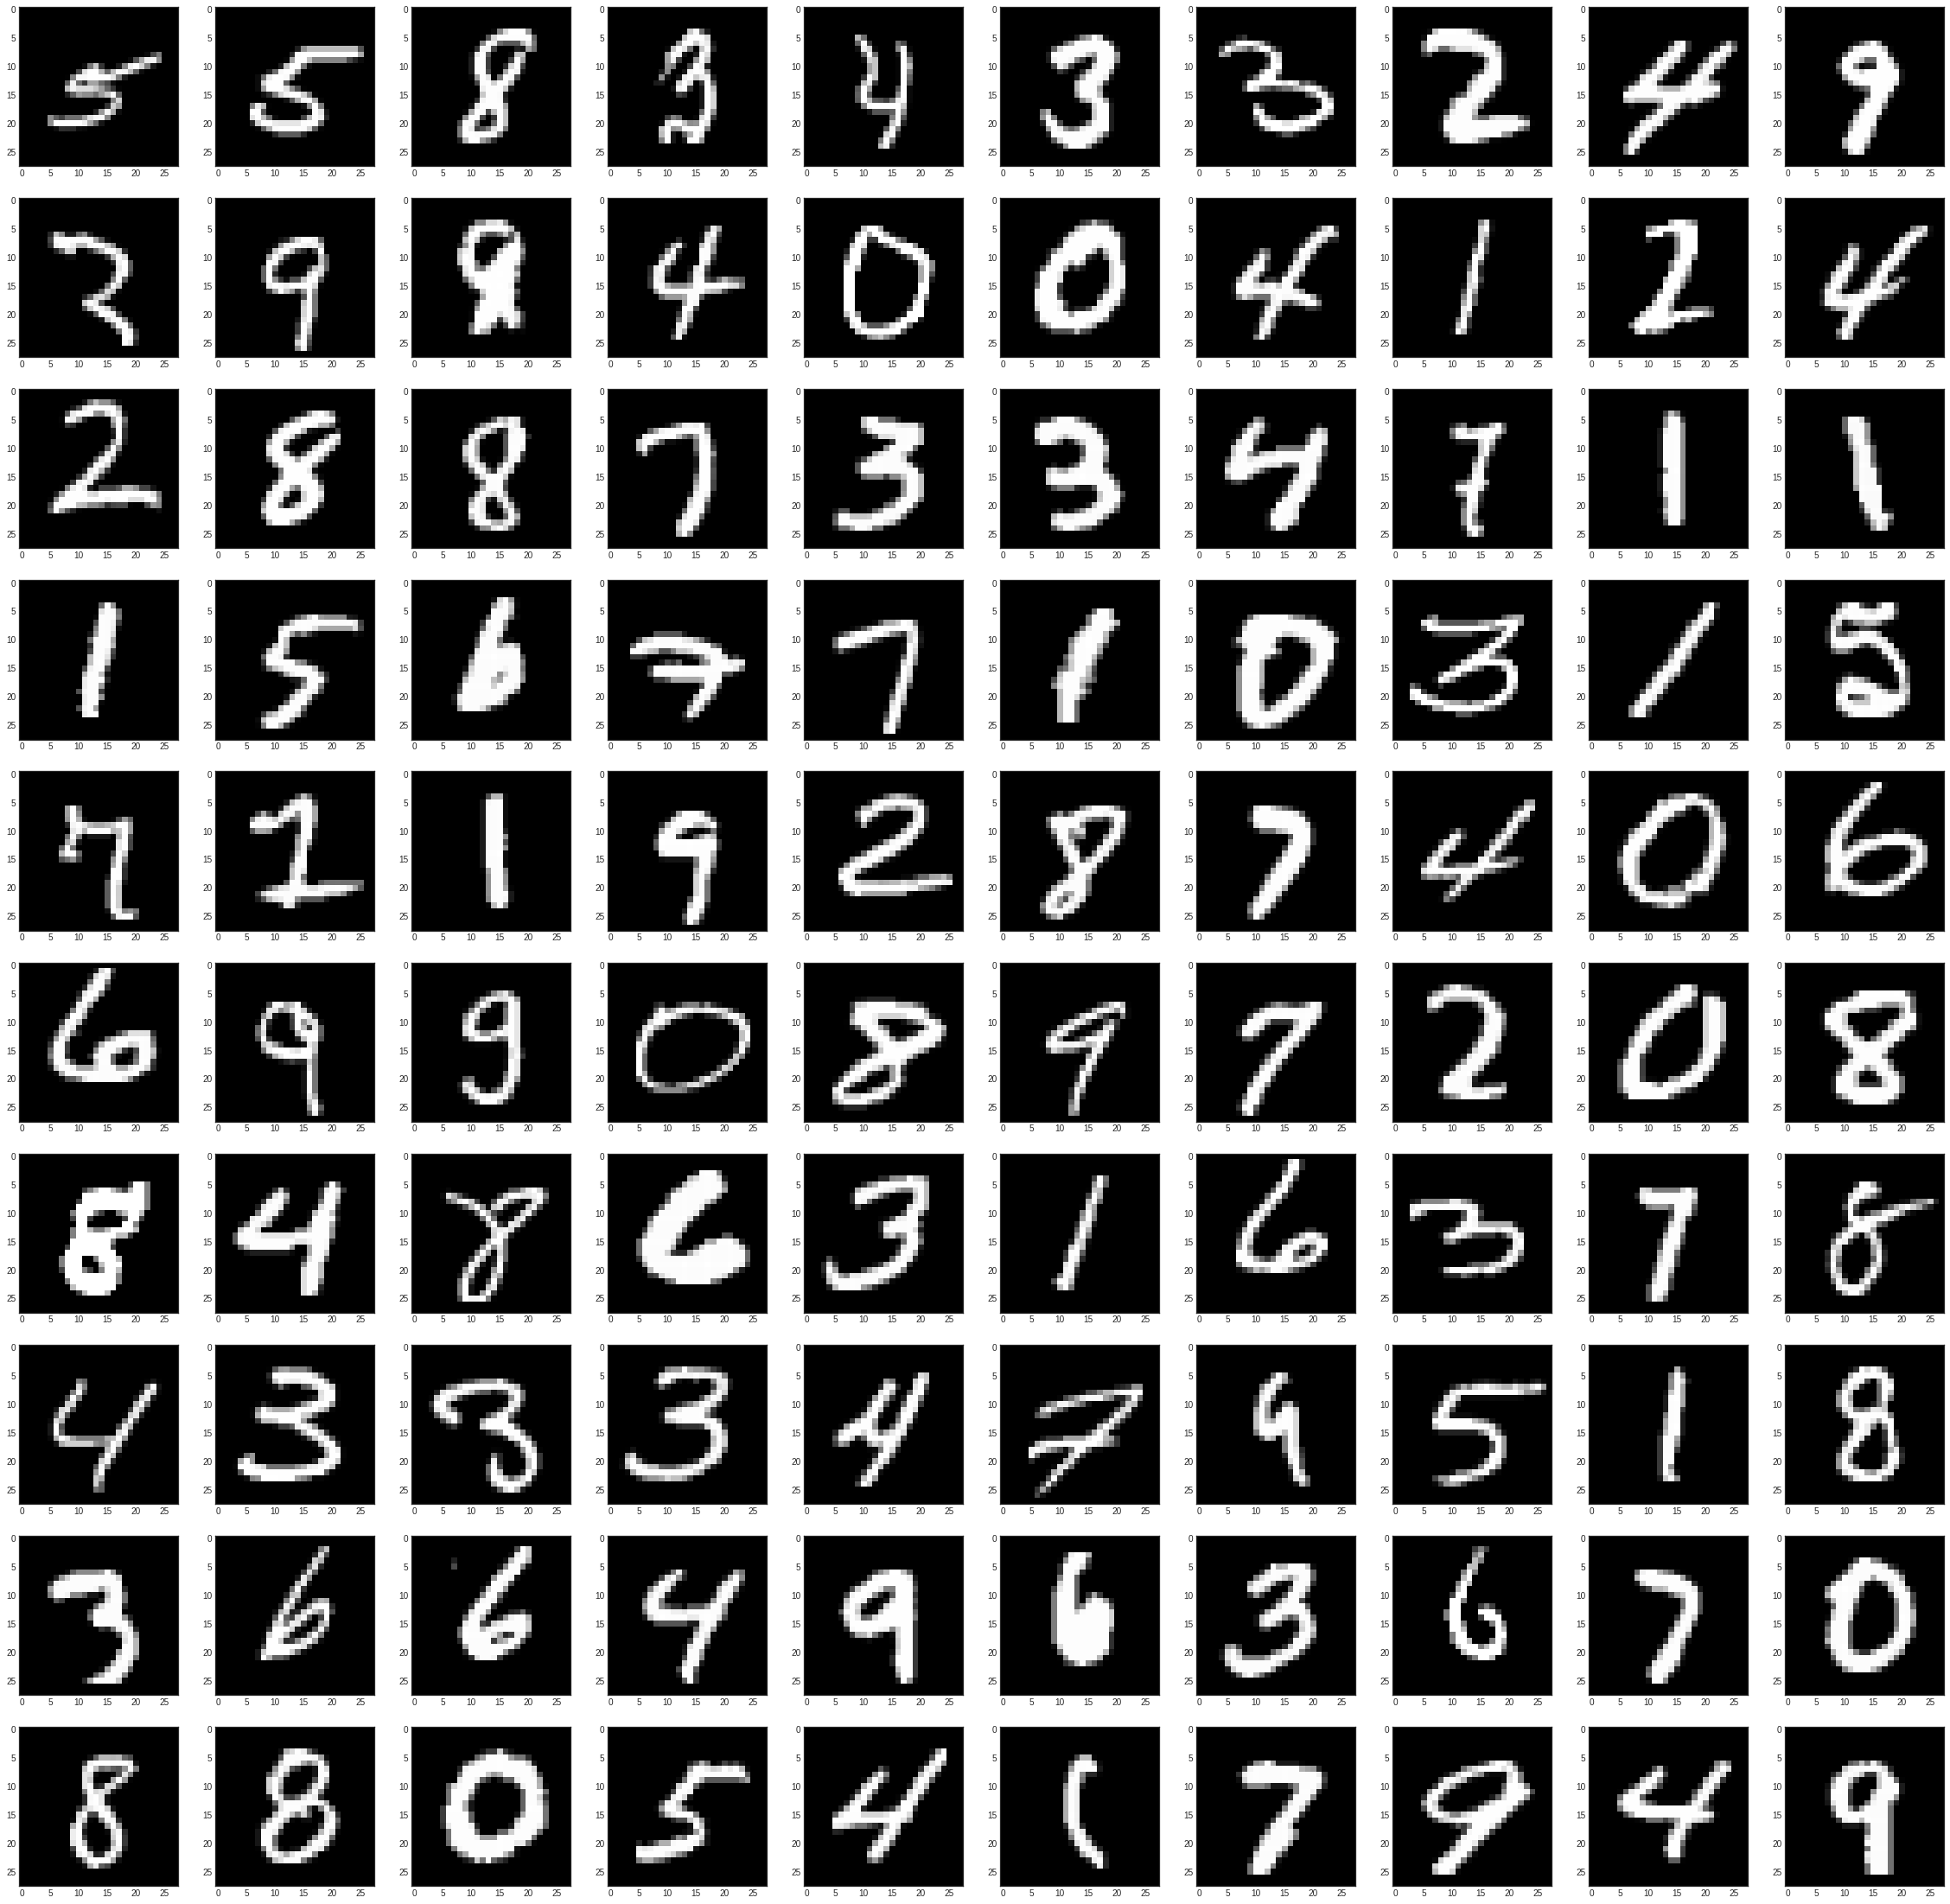

In [ ]:
plot_100_images(X_test)

# MNIST dataset

In [ ]:
(X_train_mnist, y_train_mnist), (X_test_mnist, y_test_mnist) = mnist.load_data()

In [ ]:
print(f'X_train_mnist {X_train_mnist.shape}')
print(f'y_train_mnist {y_train_mnist.shape}')
print(f'X_test_mnist {X_test_mnist.shape}')
print(f'y_test_mnist {y_test_mnist.shape}')

X_train_mnist (60000, 28, 28)
y_train_mnist (60000,)
X_test_mnist (10000, 28, 28)
y_test_mnist (10000,)


In [ ]:
X_train_mnist = X_train_mnist.reshape(60000, 28, 28, 1)
X_test_mnist = X_test_mnist.reshape(10000, 28, 28, 1)

In [ ]:
X_train_mnist = np.concatenate((X_train_mnist, X_train_mnist, X_train_mnist), axis=-1)
X_test_mnist = np.concatenate((X_test_mnist, X_test_mnist, X_test_mnist), axis=-1)

In [ ]:
print(f'X_train_mnist {X_train_mnist.shape}')
print(f'X_test_mnist {X_test_mnist.shape}')

X_train_mnist (60000, 28, 28, 3)
X_test_mnist (10000, 28, 28, 3)


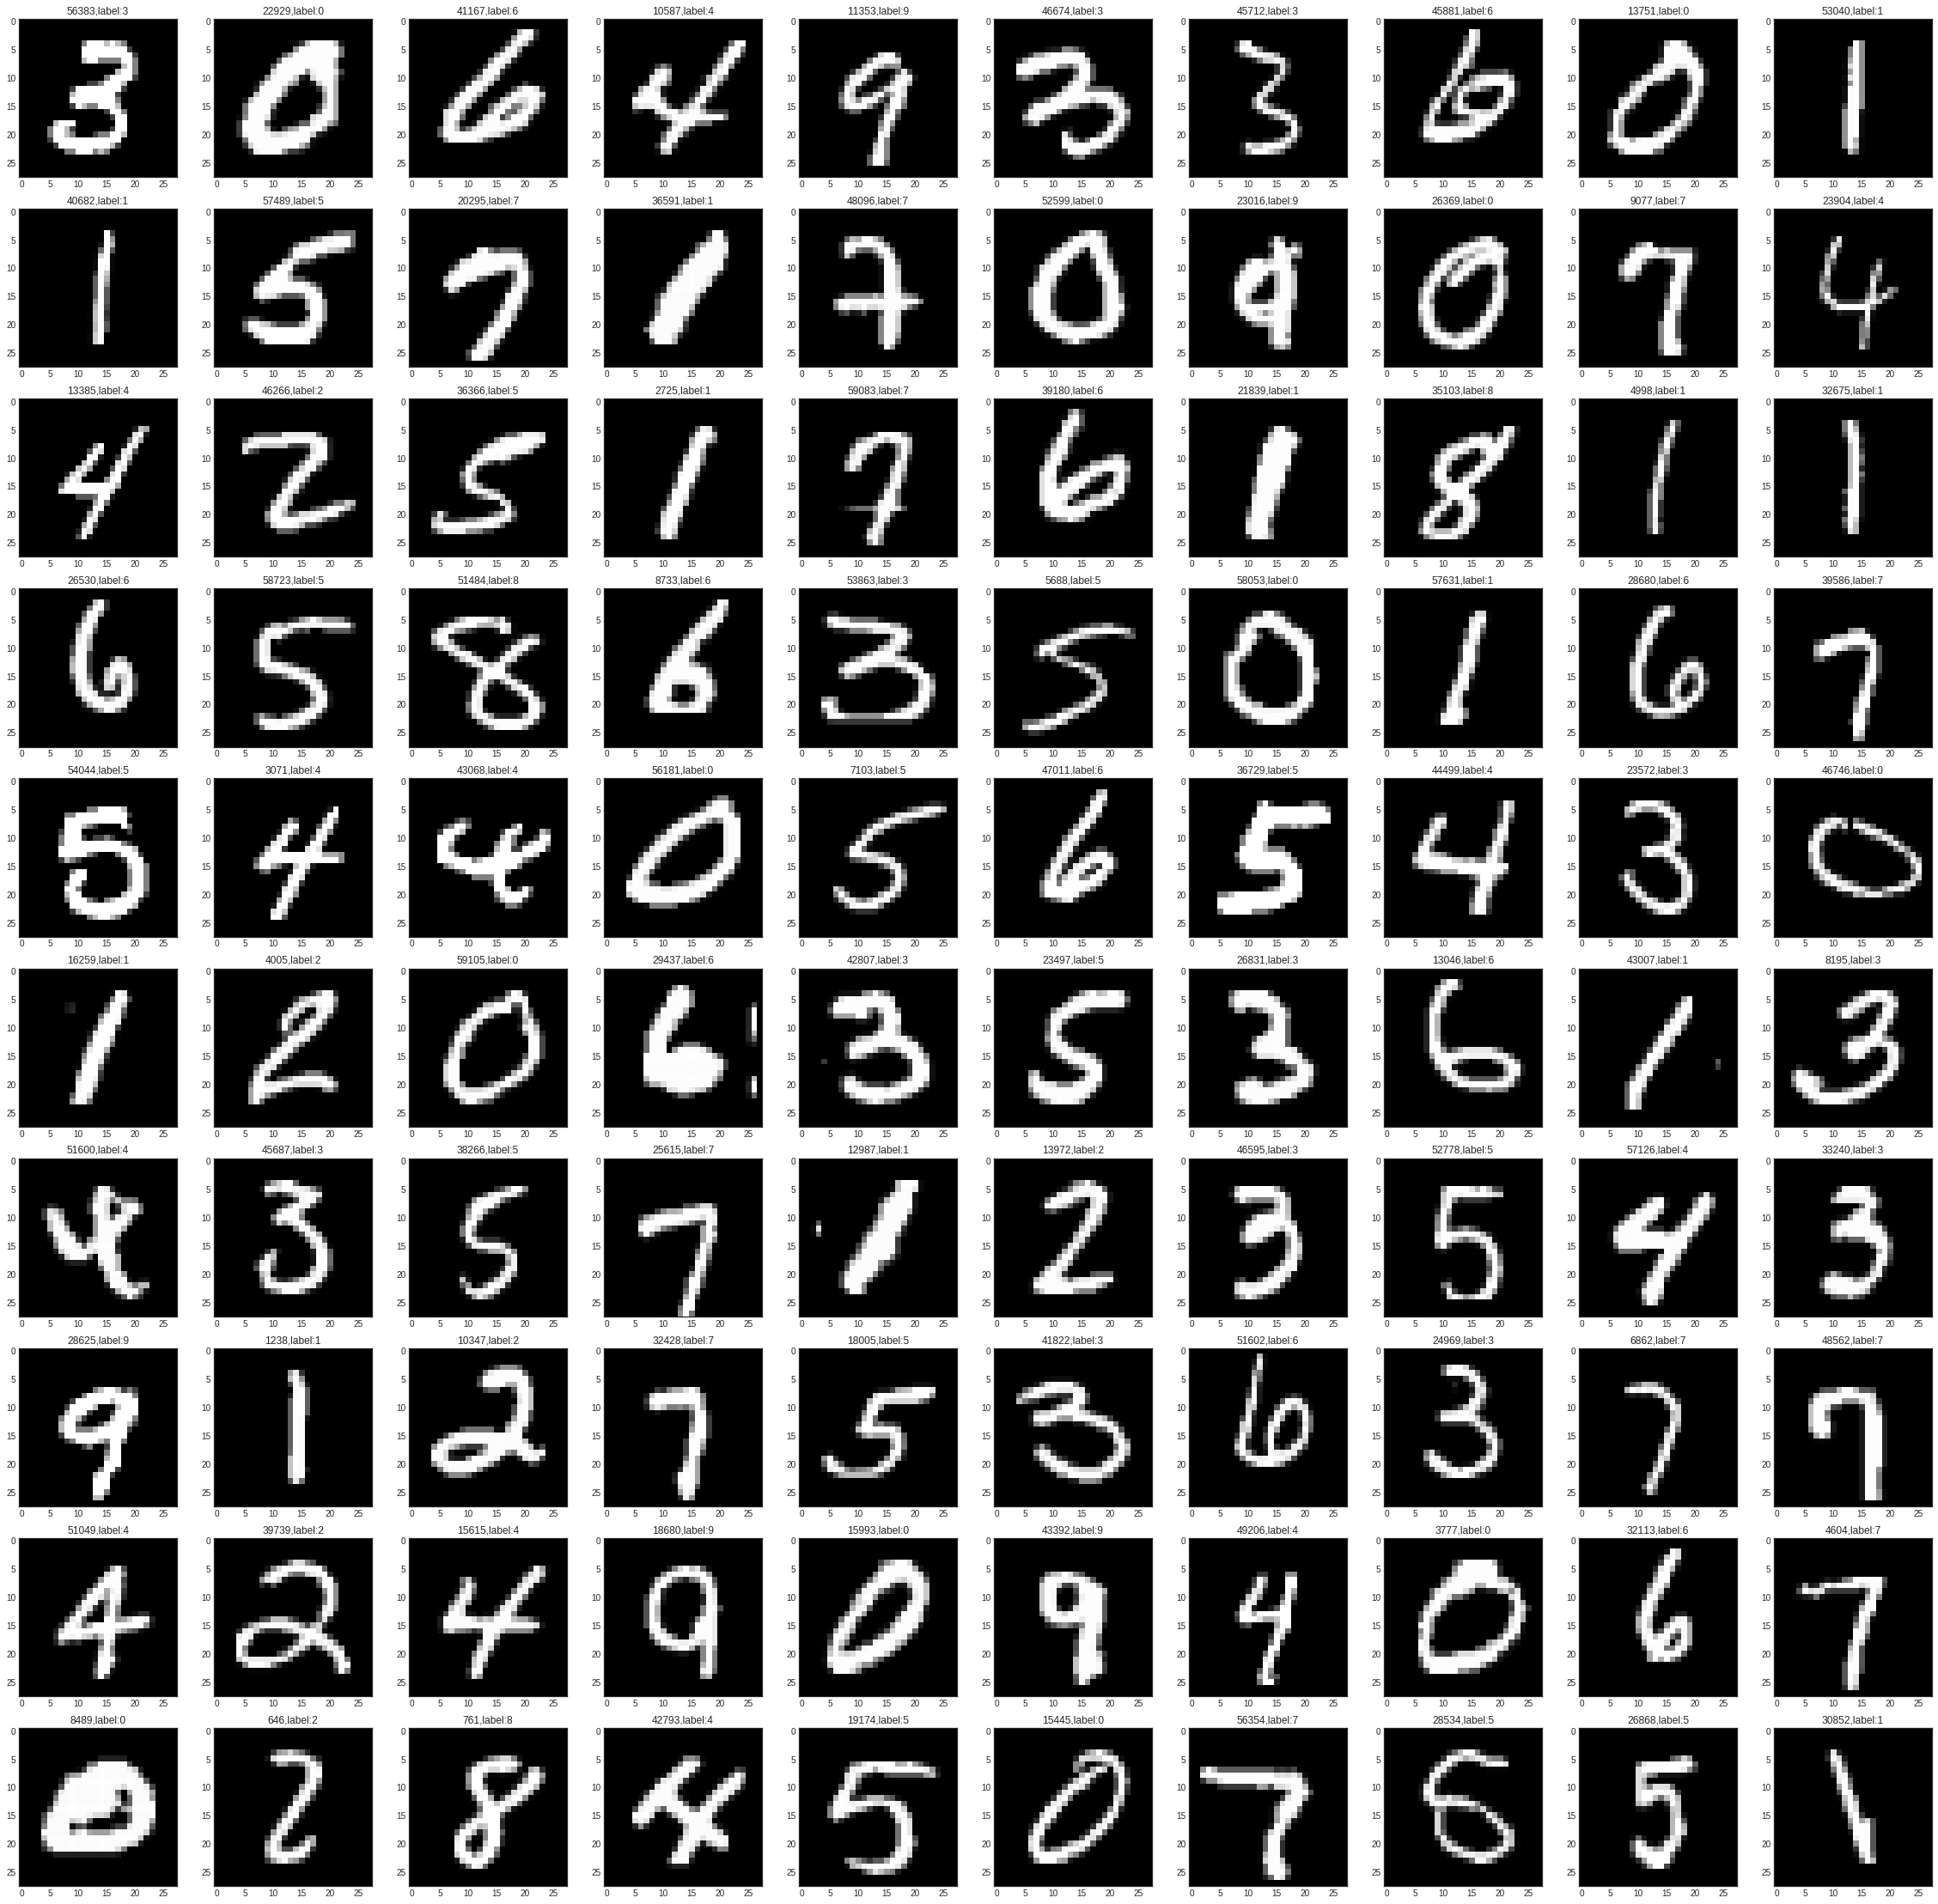

In [ ]:
plot_100_images(X_train_mnist, y_train_mnist)

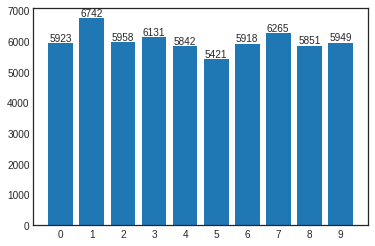

In [ ]:
plot_distribution(y_train_mnist)

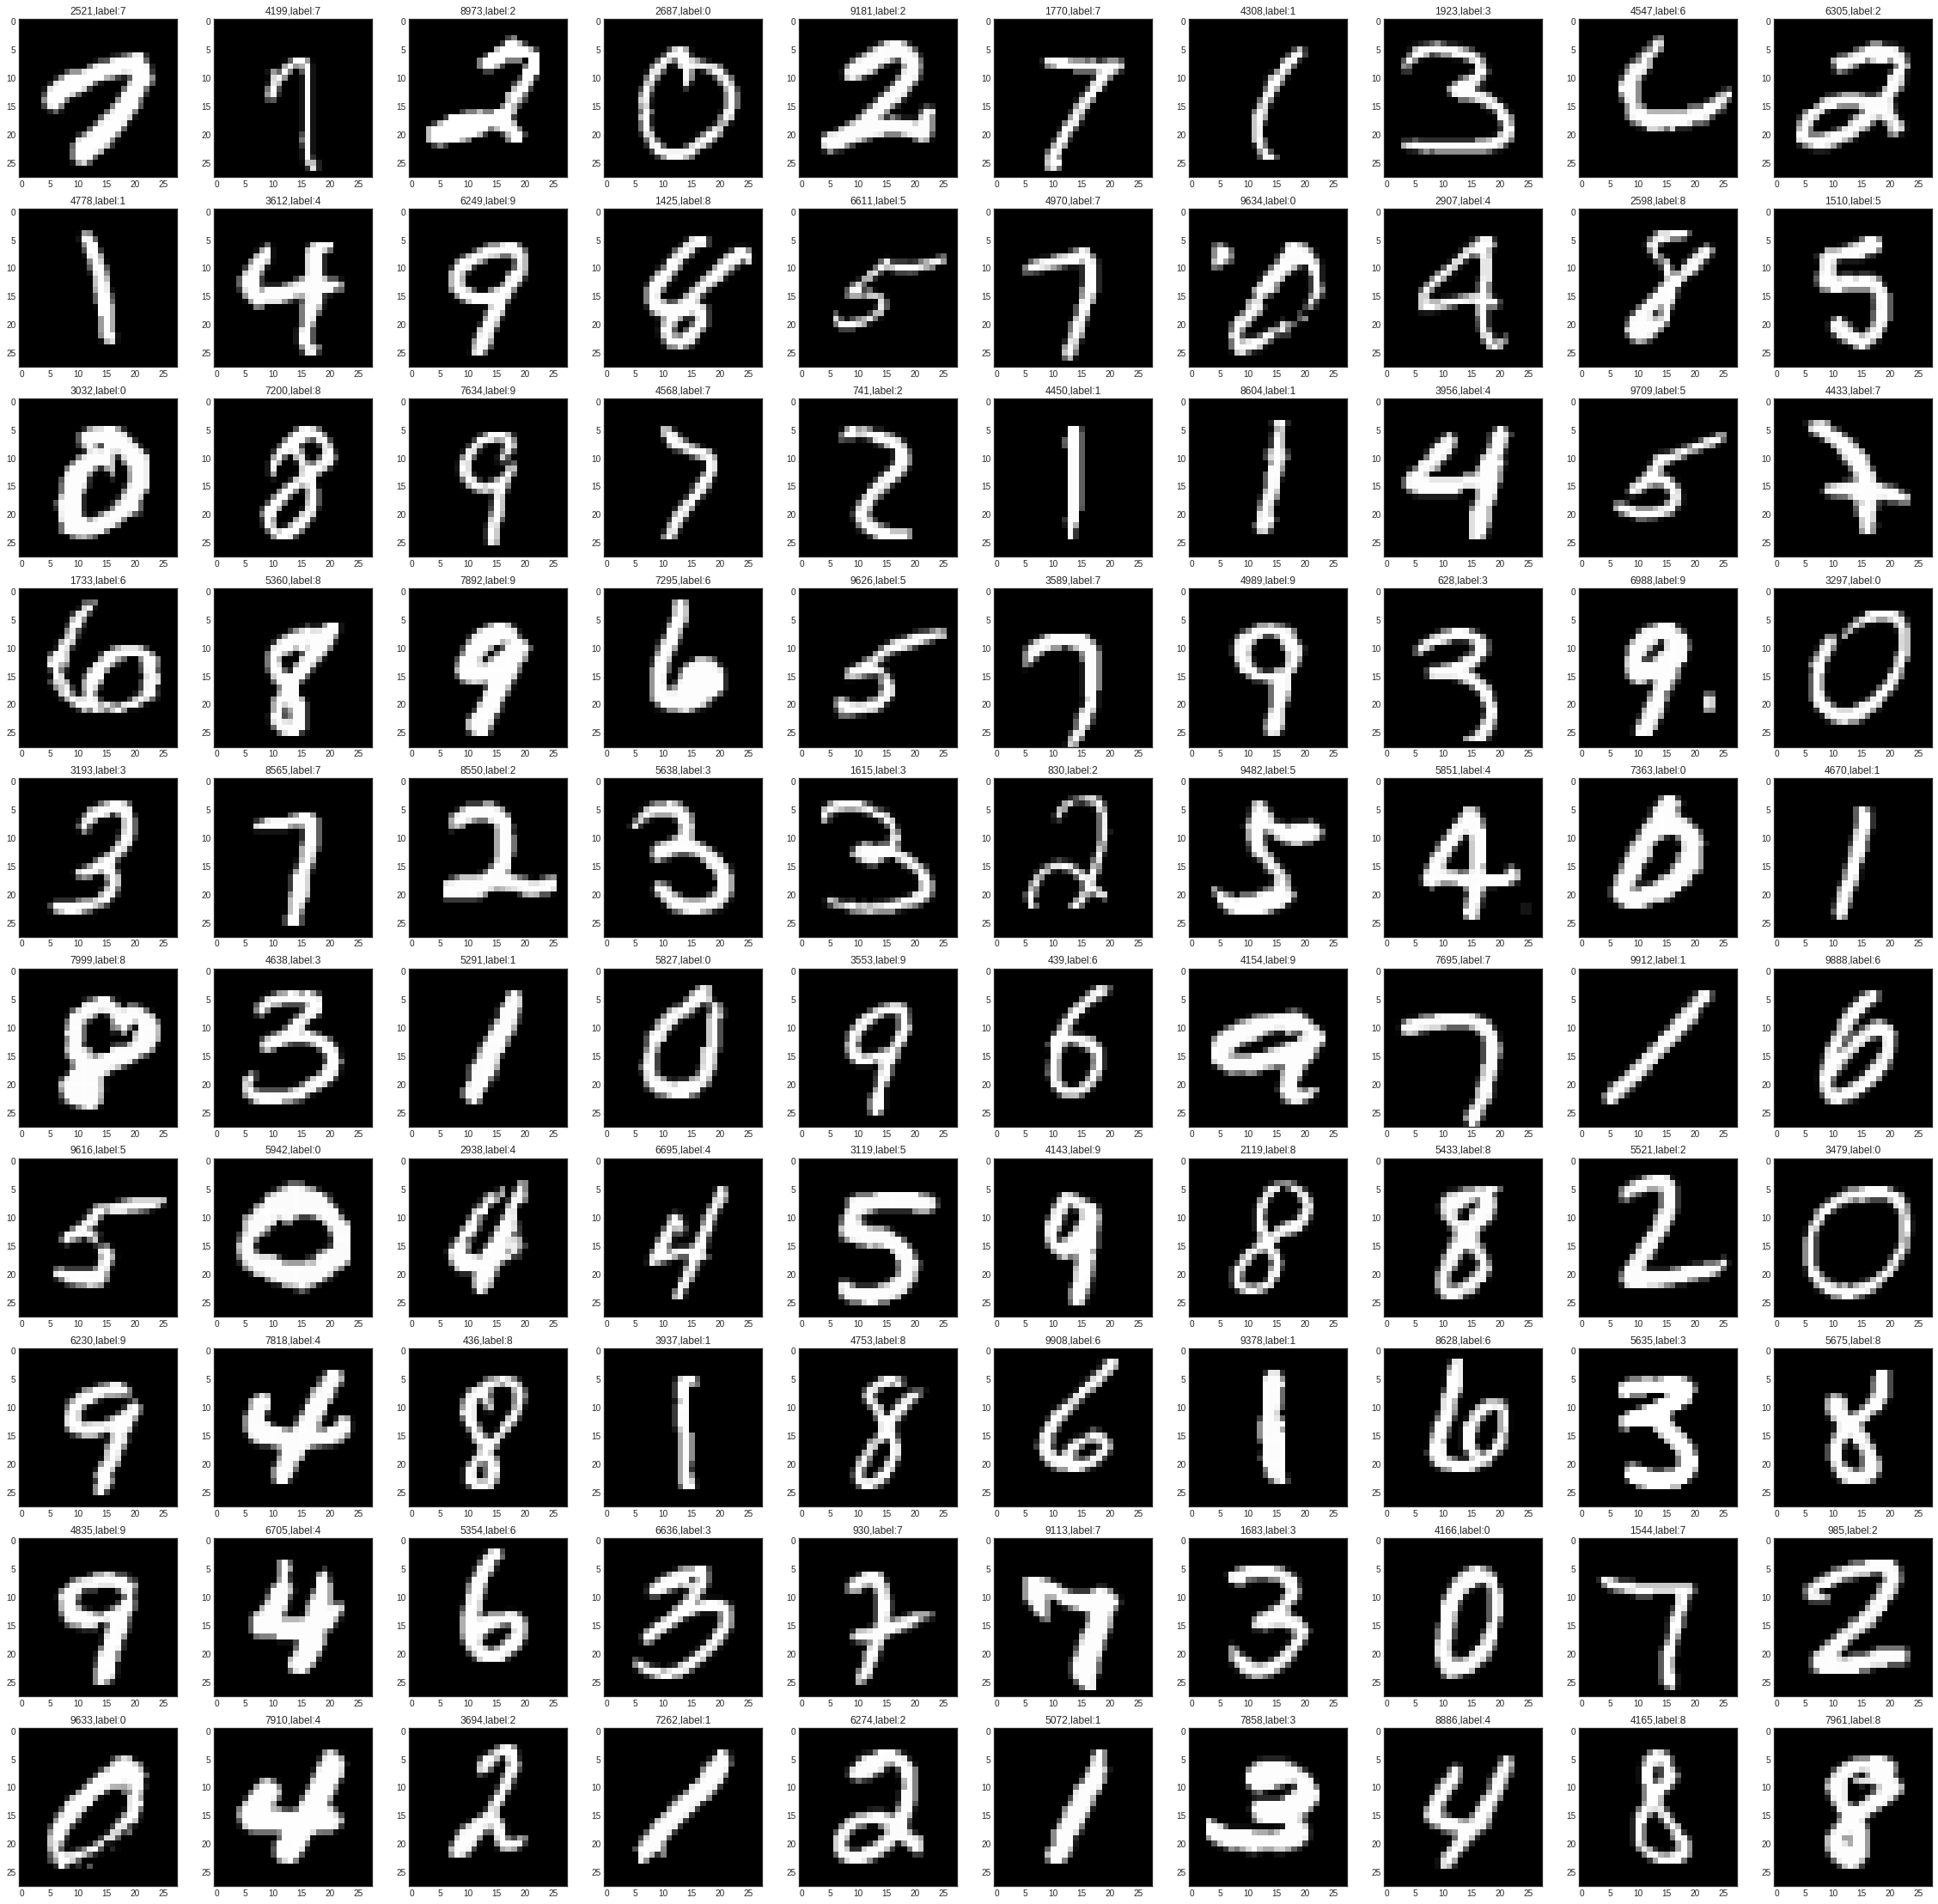

In [ ]:
plot_100_images(X_test_mnist, y_test_mnist)

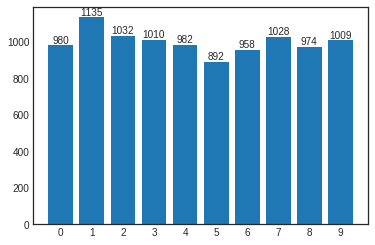

In [ ]:
plot_distribution(y_test_mnist)

# Preprocess Image

In [ ]:
X = np.concatenate((X, X_train_mnist, X_test_mnist))
label = np.concatenate((label, y_train_mnist, y_test_mnist))

In [ ]:
X.shape, label.shape

((112000, 28, 28, 3), (112000,))

In [ ]:
X_preprocess = normalize(X)
X_preprocess

array([[[[0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         ...,
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.]],

        [[0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         ...,
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.]],

        [[0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         ...,
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.]],

        ...,

        [[0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         ...,
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.]],

        [[0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         ...,
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.]],

        [[0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         ...,
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.]]],


       [[[0., 0., 0.],
         [0., 0., 0.],
         [0., 

In [ ]:
X_test_preprocessed = normalize(X_test)
X_test_preprocessed

array([[[[0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         ...,
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.]],

        [[0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         ...,
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.]],

        [[0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         ...,
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.]],

        ...,

        [[0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         ...,
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.]],

        [[0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         ...,
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.]],

        [[0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         ...,
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.]]],


       [[[0., 0., 0.],
         [0., 0., 0.],
         [0., 

In [ ]:
# encoder = preprocessor.OneHotEncoder(sparse=False)
# Y = encoder.fit_transform(label.reshape(-1, 1))
# Y[0]
Y = label

# Train Dev Split

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_preprocess, Y, test_size=0.2,random_state=42)

In [ ]:
print(f'X_train shape = {X_train.shape}')
print(f'y_train shape = {y_train.shape}')
print(f'X_test shape = {X_test.shape}')
print(f'y_test shape = {y_test.shape}')

X_train shape = (89600, 28, 28, 3)
y_train shape = (89600,)
X_test shape = (22400, 28, 28, 3)
y_test shape = (22400,)


# Data Augmentation with ImageDataGenerator

In [ ]:
data_generator = ImageDataGenerator(rotation_range=20,
                                    width_shift_range=0.2,
                                    shear_range=15,
                                    zoom_range=0.1,
                                    validation_split=0.2,
                                    horizontal_flip=False)


In [ ]:
data_generator.fit(X_train)

In [ ]:
def train_generator(X_train, y_train, batch_size=16): 
  gen = data_generator.flow(X_train, y_train, batch_size=16, subset='training')
  while True:
    data = gen.next()
    yield [data[0], data[1]], data[1]

def validation_generator(X_train, y_train, batch_size=8): 
  gen = data_generator.flow(X_train, y_train, batch_size=8, subset='validation')
  while True:
    data = gen.next()
    yield [data[0], data[1]], data[1]


# Models

In [ ]:
INPUT_SIZE = (28, 28, 3)
num_classes = 10

In [ ]:
model = ArcModel(INPUT_SIZE, num_classes, 512)
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_image (InputLayer)        [(None, 28, 28, 3)]  0                                            
__________________________________________________________________________________________________
model (Functional)              (None, 512)          1051488     input_image[0][0]                
__________________________________________________________________________________________________
label (InputLayer)              [(None,)]            0                                            
__________________________________________________________________________________________________
model_1 (Functional)            (None, 10)           5120        model[0][0]                      
                                                                 label[0][0]                

/usr/local/lib/python3.7/dist-packages/keras/engine/base_layer.py:2223: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  warnings.warn('`layer.add_variable` is deprecated and '


In [ ]:
INIT_LR = 1e-3
EPOCHS = 150
TRAIN_BATCH_SIZE = 16
VAL_BATCH_SIZE = 8
VAL_SPLIT = 0.2

In [ ]:
opt = Adam(learning_rate=INIT_LR, decay=INIT_LR / EPOCHS)
# model.compile(loss="categorical_crossentropy", optimizer=opt,
# 	            metrics=["accuracy"])
model.compile(loss=SoftmaxLoss(), optimizer=opt,
	            metrics=["accuracy"])

In [ ]:
checkpoint = ModelCheckpoint(filepath='HwR_ver3_09_10.h5',
                             monitor='val_loss',
                             save_best_only=True,
                             save_weights_only=True,
                             verbose=1)

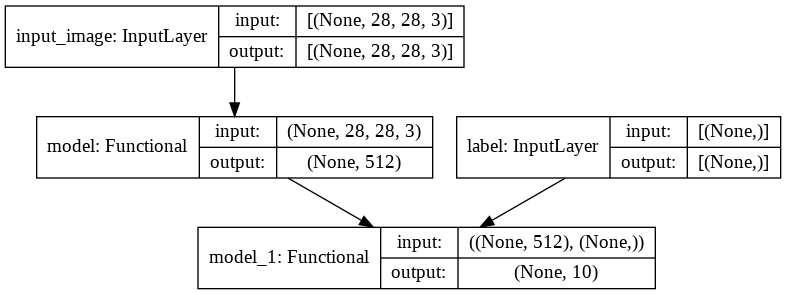

In [ ]:
tf.keras.utils.plot_model(
    model,
    to_file="model.png",
    show_shapes=True,
    show_dtype=False,
    show_layer_names=True,
    rankdir="TB",
    expand_nested=False,
    dpi=96,
)

In [ ]:
H = model.fit(train_generator(X_train, y_train),
              steps_per_epoch=len(X_train)//TRAIN_BATCH_SIZE,
              validation_data=validation_generator(X_train, y_train),
              validation_steps=(len(X_train)*VAL_SPLIT)//VAL_BATCH_SIZE,
              epochs=EPOCHS,
              callbacks=[checkpoint])

Epoch 1/150
5600/5600 [==============================] - 146s 20ms/step - loss: 3.7097 - accuracy: 0.8344 - val_loss: 2.2187 - val_accuracy: 0.9062

Epoch 00001: val_loss improved from inf to 2.21871, saving model to HwR_ver3_09_10.h5
Epoch 2/150
5600/5600 [==============================] - 114s 20ms/step - loss: 1.8418 - accuracy: 0.9222 - val_loss: 1.7566 - val_accuracy: 0.9301

Epoch 00002: val_loss improved from 2.21871 to 1.75656, saving model to HwR_ver3_09_10.h5
Epoch 3/150
5600/5600 [==============================] - 115s 21ms/step - loss: 1.4022 - accuracy: 0.9418 - val_loss: 1.2304 - val_accuracy: 0.9522

Epoch 00003: val_loss improved from 1.75656 to 1.23036, saving model to HwR_ver3_09_10.h5
Epoch 4/150
5600/5600 [==============================] - 115s 21ms/step - loss: 1.1852 - accuracy: 0.9518 - val_loss: 1.4140 - val_accuracy: 0.9506

Epoch 00004: val_loss did not improve from 1.23036
Epoch 5/150
5600/5600 [==============================] - 116s 21ms/step - loss: 1.0465 

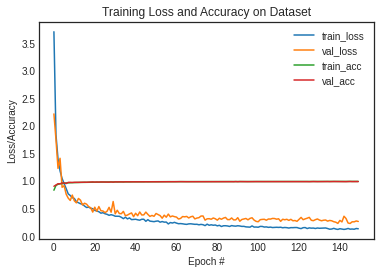

In [ ]:
plt.figure()
plt.plot(np.arange(0, EPOCHS), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, EPOCHS), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, EPOCHS), H.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, EPOCHS), H.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy on Dataset")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="best")
plt.show()

In [ ]:
model.evaluate((X_test, y_test), y_test)

700/700 [==============================] - 4s 6ms/step - loss: 0.1906 - accuracy: 0.9943


[0.19060176610946655, 0.9942857027053833]

In [ ]:
! cp '/content/drive/MyDrive/Kaggle/Handwritten Digits Recognition/HwR_ver3_09_10.h5' './'

# Load model

In [ ]:
model.load_weights('HwR_ver3_09_10.h5')

# Analysis Wrong Case

## Train

In [ ]:
y_pred = model.predict((X_train, y_train))

In [ ]:
y_preds = np.array(list(map(np.argmax, y_pred)))
y_preds

array([0, 3, 0, ..., 8, 6, 0])

In [ ]:
# y_true = np.array(list(map(np.argmax, y_train)))
y_true=y_train
y_true

array([0, 3, 0, ..., 8, 6, 0])

In [ ]:
print(metrics.classification_report(y_preds, y_true))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      8754
           1       1.00      1.00      1.00      9991
           2       1.00      1.00      1.00      8992
           3       1.00      1.00      1.00      9237
           4       1.00      1.00      1.00      8711
           5       1.00      1.00      1.00      8056
           6       1.00      1.00      1.00      8836
           7       0.99      1.00      0.99      9338
           8       1.00      1.00      1.00      8767
           9       0.99      1.00      1.00      8918

    accuracy                           1.00     89600
   macro avg       1.00      1.00      1.00     89600
weighted avg       1.00      1.00      1.00     89600



In [ ]:
errors = (y_preds - y_true) != 0
y_preds_error =  y_preds[errors]
y_true_error = y_true[errors]
X_train_error = X_train[errors]

In [ ]:
len(y_preds_error)

256

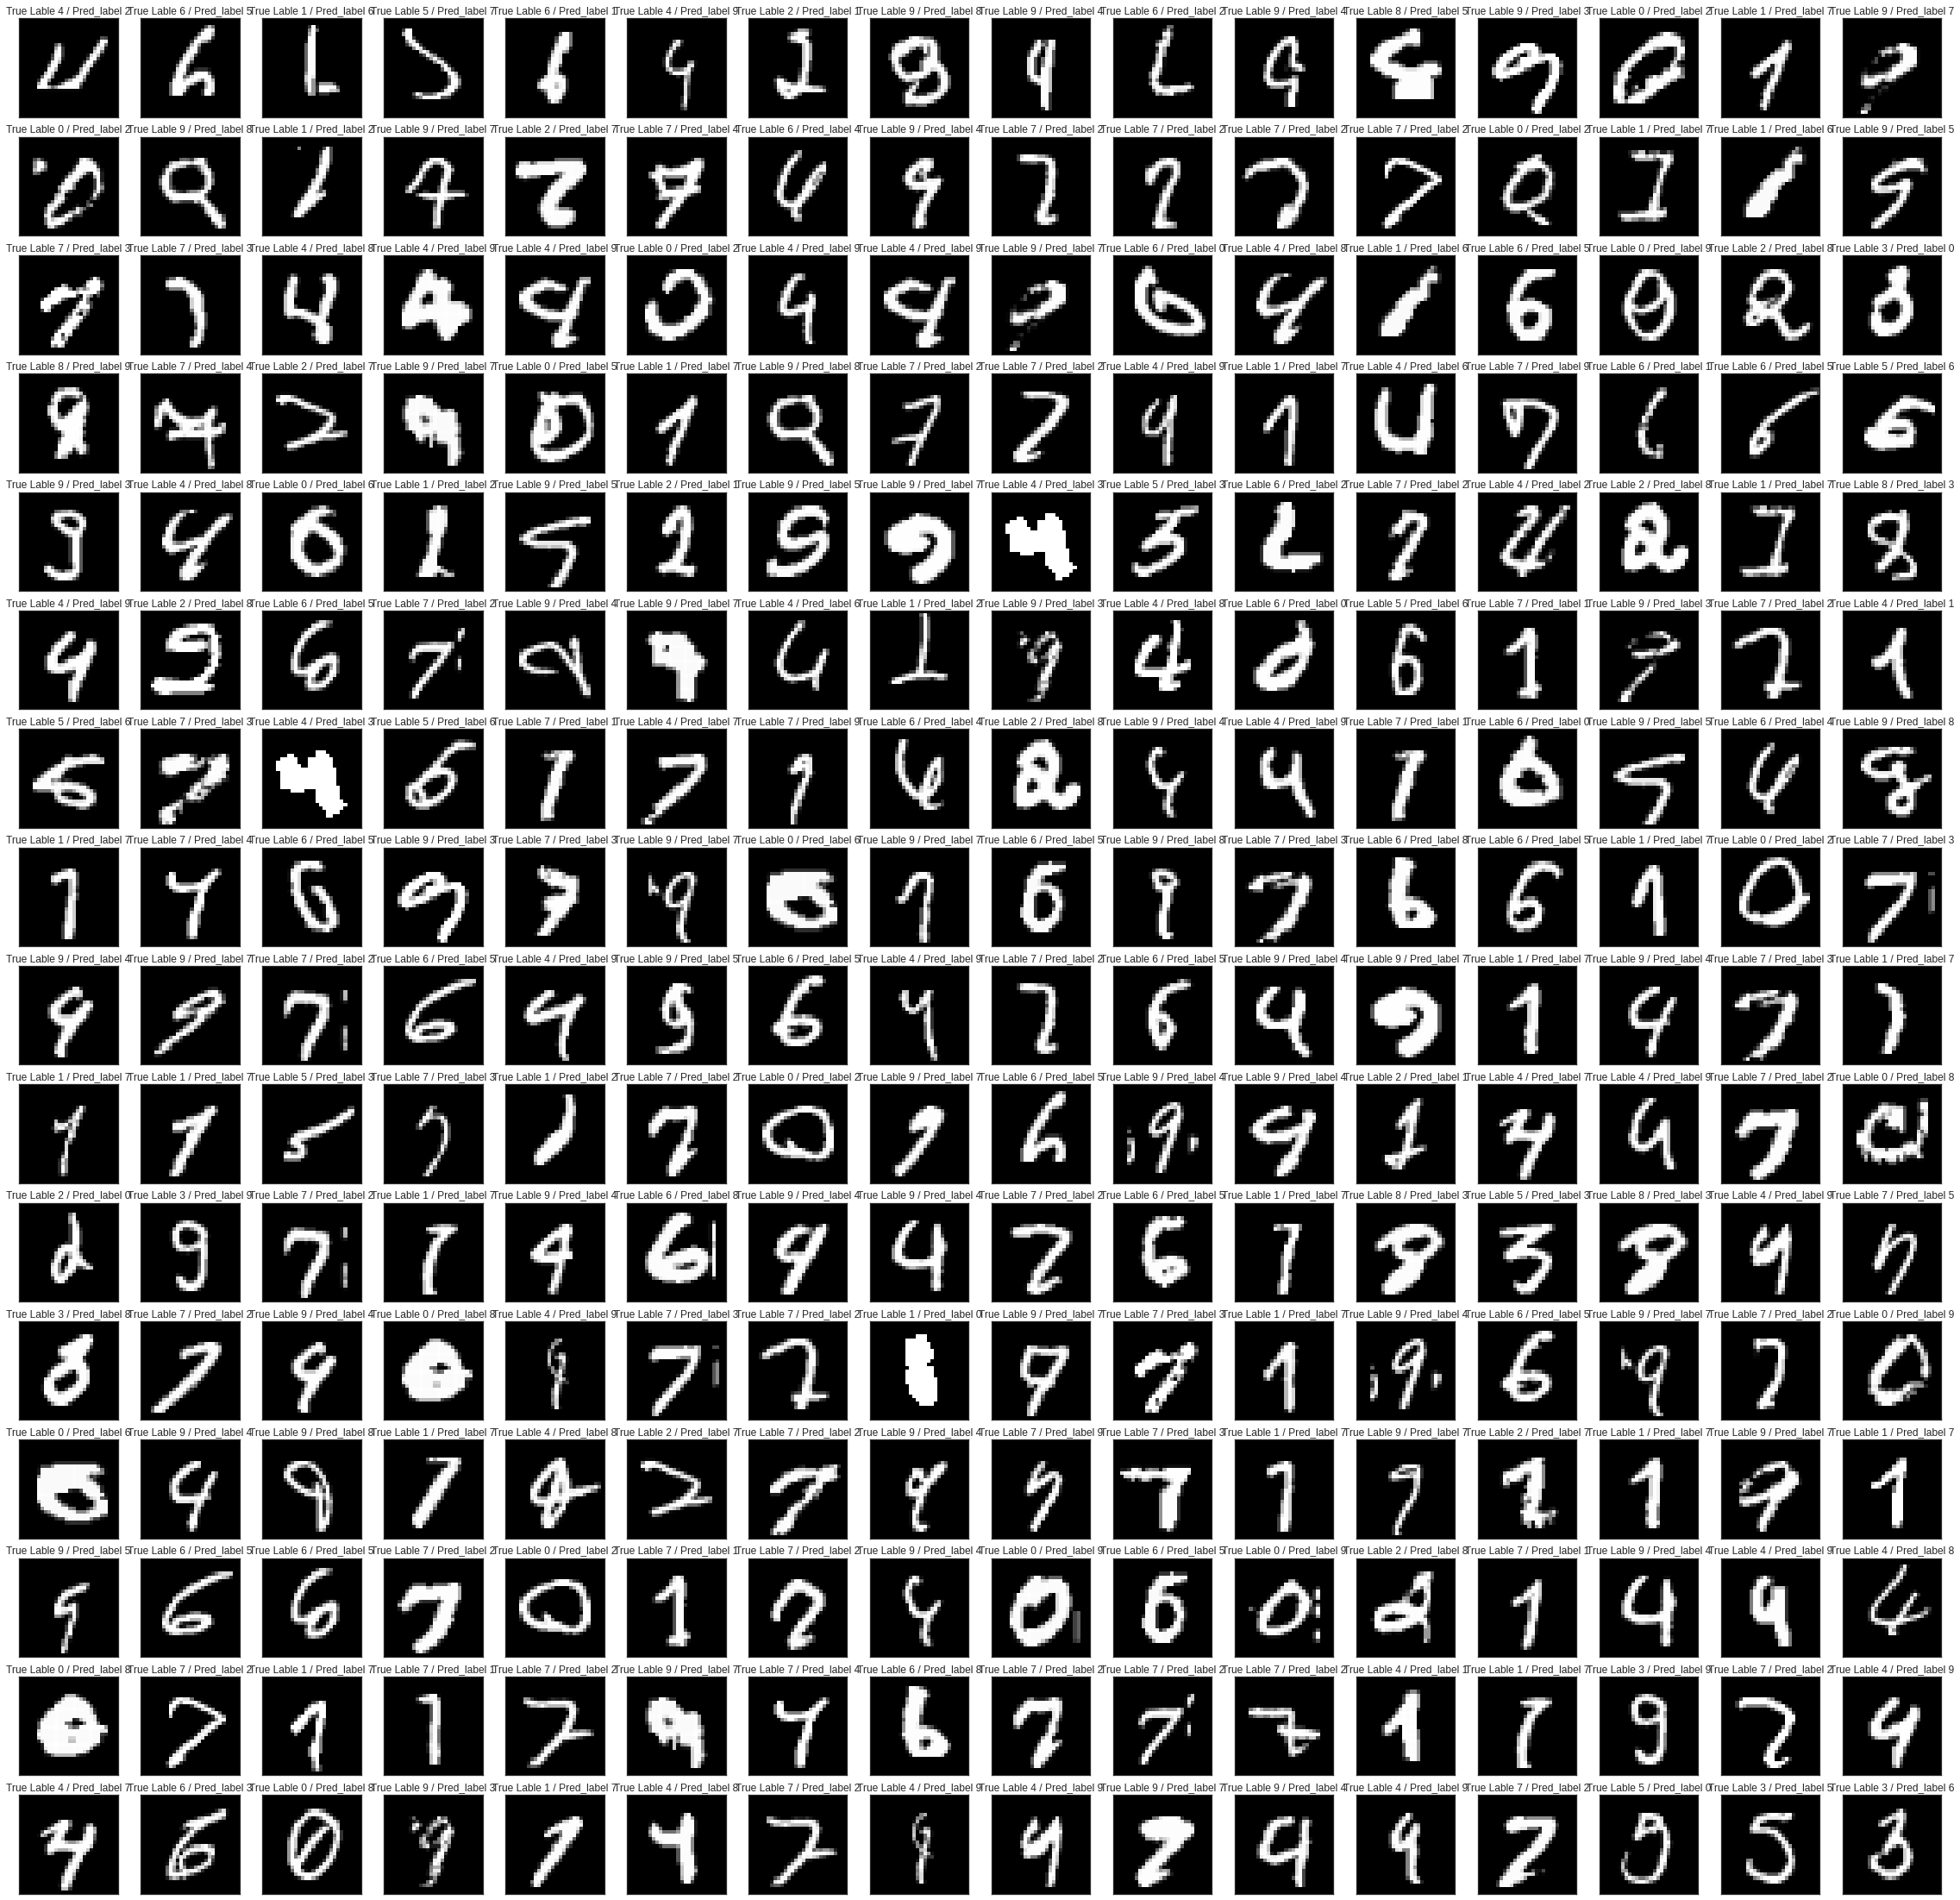

In [ ]:
plt.figure(figsize=(40, 40))
for i in range(len(y_preds_error)):
  plt.subplot(16, 16, i+1)
  plt.imshow(X_train_error[i])
  plt.title(f'True Lable {y_true_error[i]} / Pred_label {y_preds_error[i]}')
  plt.xticks(())
  plt.yticks(())

In [ ]:
confusion_mtx = metrics.confusion_matrix(y_true, y_preds)

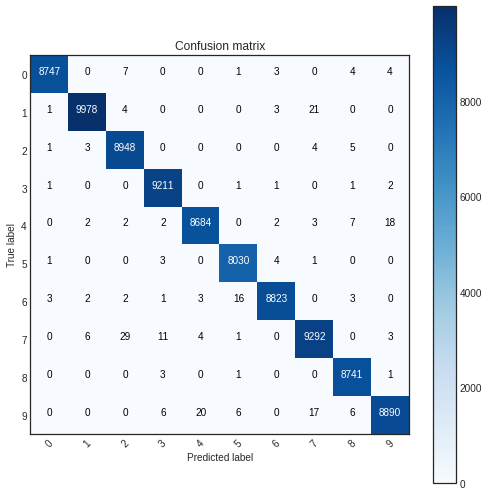

In [ ]:
plot_confusion_matrix(confusion_mtx, classes=range(10))

## Test

In [ ]:
y_pred = model.predict((X_test, y_test))

In [ ]:
y_preds = np.array(list(map(np.argmax, y_pred)))
y_preds

array([3, 5, 3, ..., 5, 2, 2])

In [ ]:
y_true = y_test
y_true

array([3, 5, 3, ..., 5, 2, 2])

In [ ]:
print(metrics.classification_report(y_preds, y_true))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      2262
           1       0.99      1.00      1.00      2546
           2       0.99      0.99      0.99      2199
           3       1.00      0.99      1.00      2282
           4       0.99      0.99      0.99      2171
           5       1.00      0.99      1.00      2074
           6       1.00      1.00      1.00      2161
           7       0.99      0.99      0.99      2358
           8       1.00      0.99      0.99      2153
           9       0.99      0.99      0.99      2194

    accuracy                           0.99     22400
   macro avg       0.99      0.99      0.99     22400
weighted avg       0.99      0.99      0.99     22400



In [ ]:
errors = (y_preds - y_true) != 0
y_preds_error =  y_preds[errors]
y_true_error = y_true[errors]
X_test_error = X_test[errors]

In [ ]:
len(y_preds_error)

128

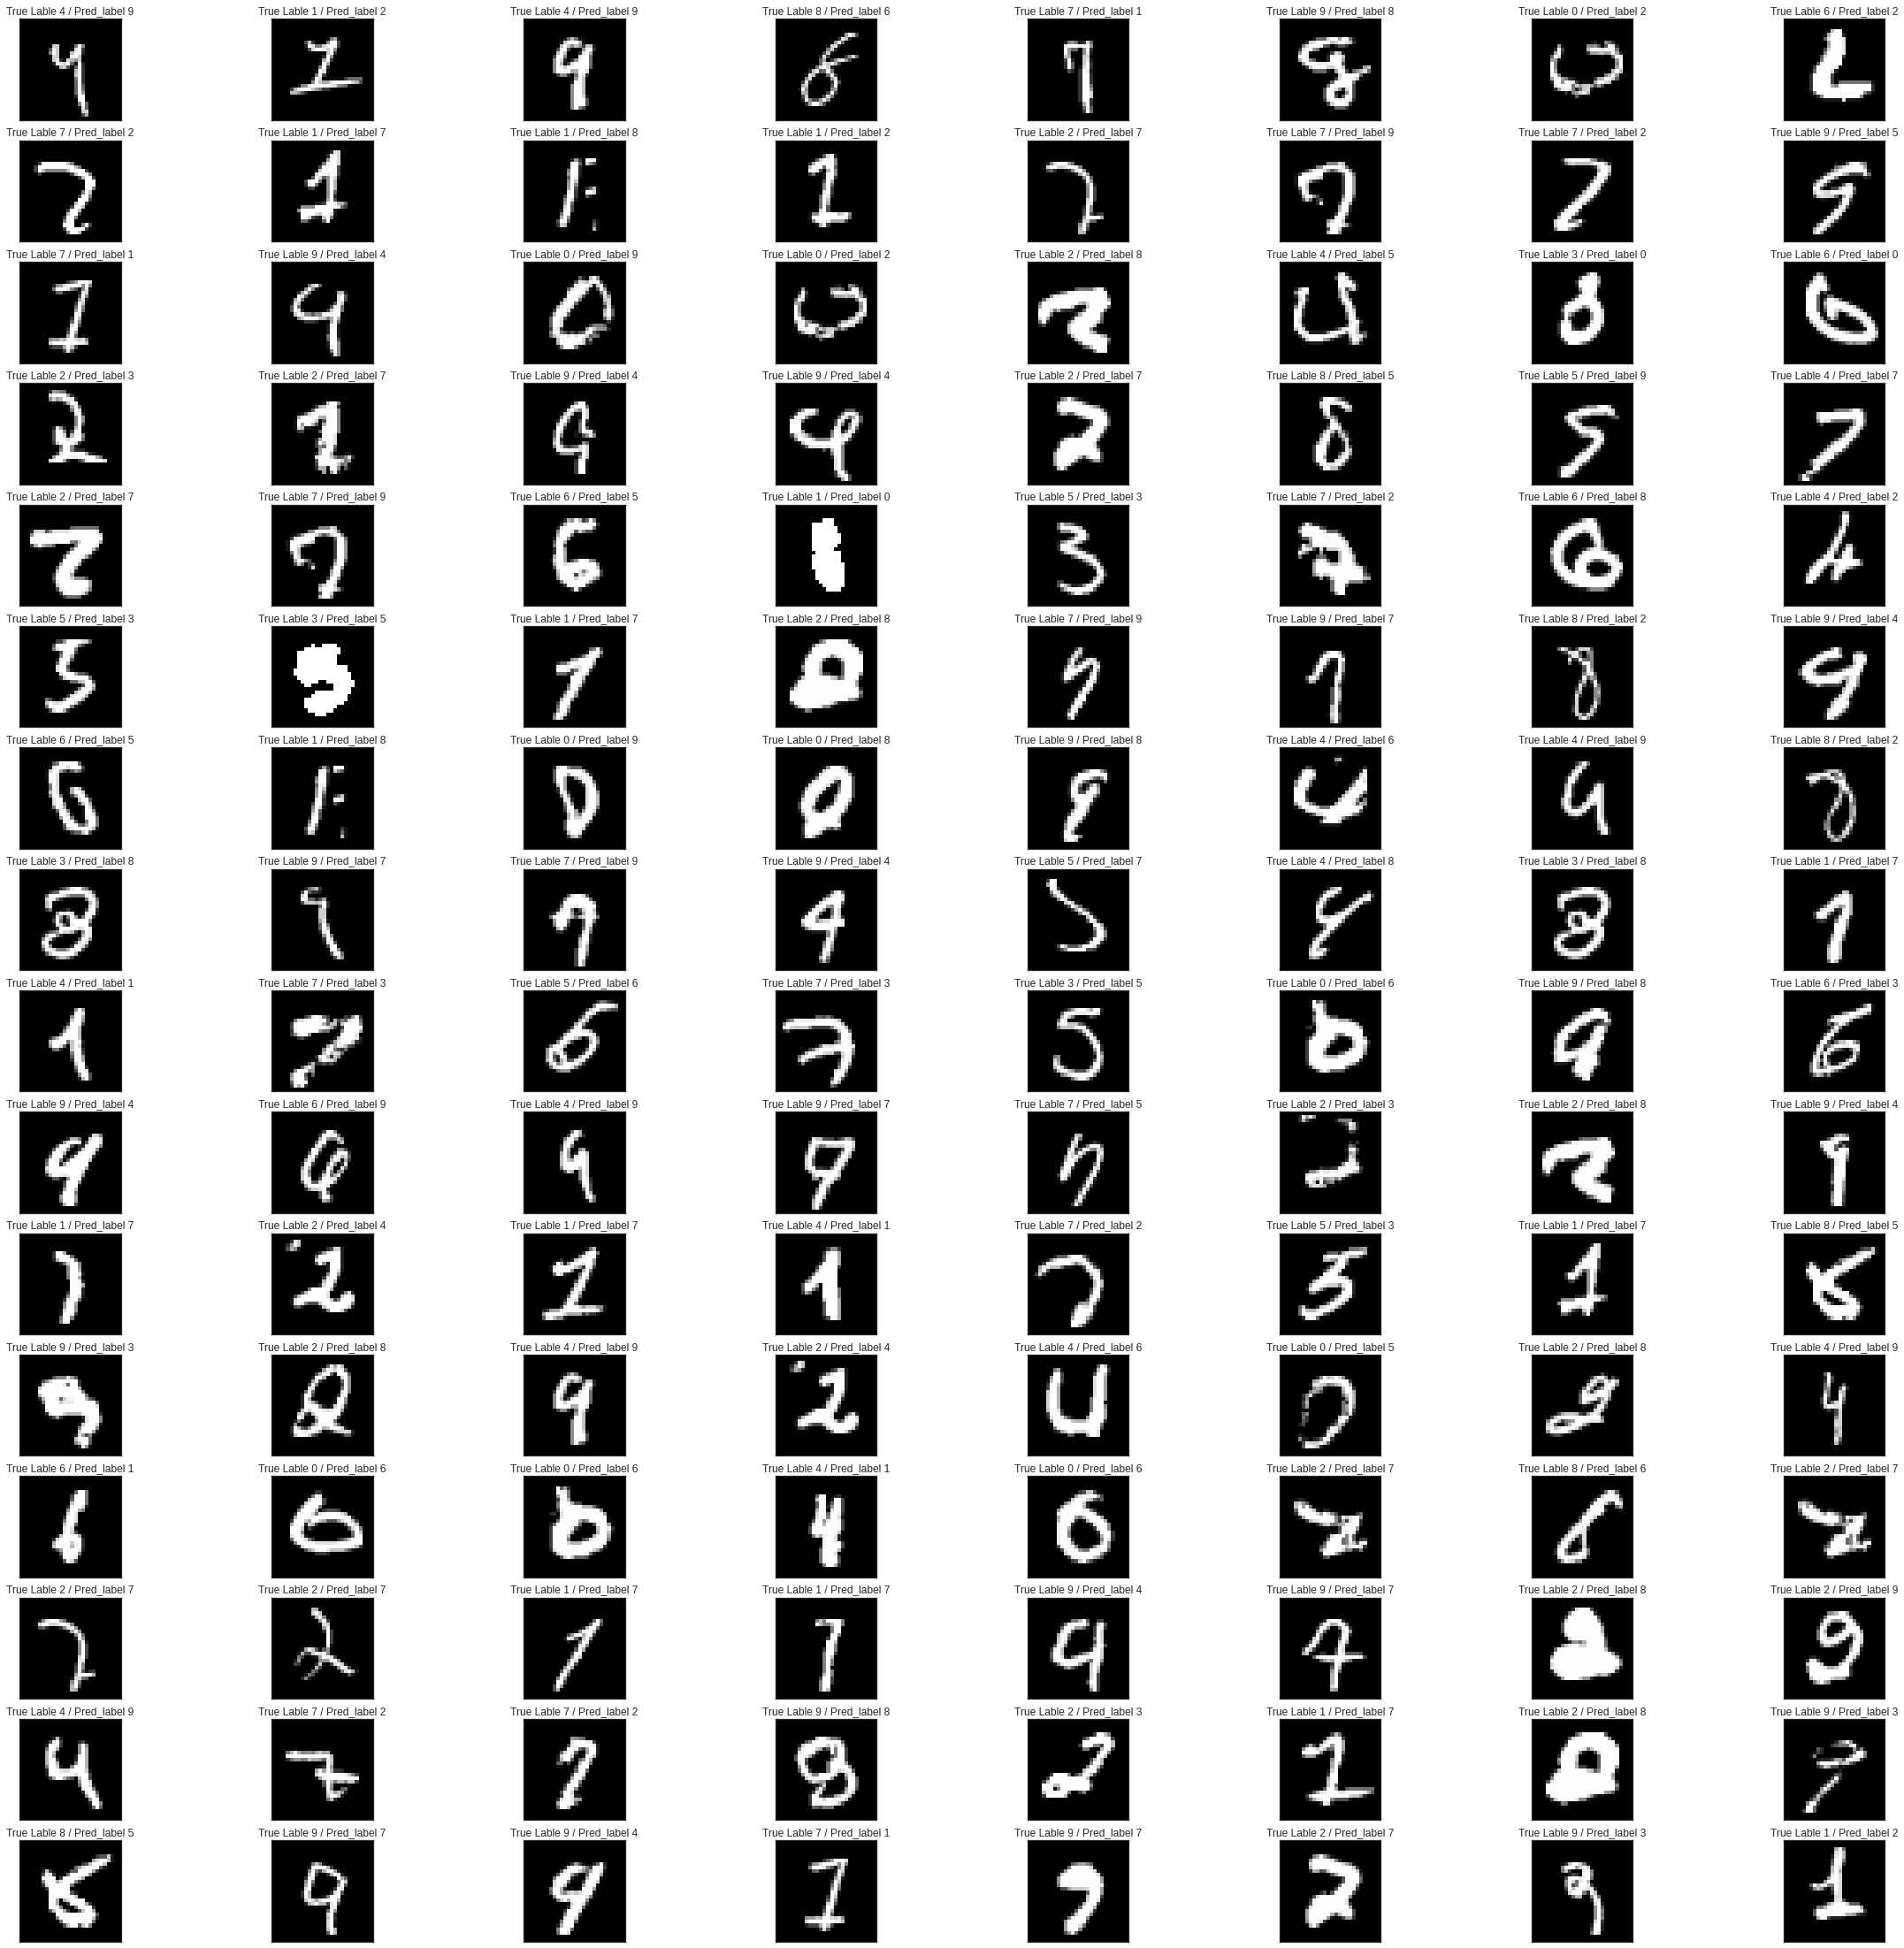

In [ ]:
plt.figure(figsize=(40, 40))
for i in range(len(y_preds_error)):
  plt.subplot(16, 8, i+1)
  plt.imshow(X_test_error[i])
  plt.title(f'True Lable {y_true_error[i]} / Pred_label {y_preds_error[i]}')
  plt.xticks(())
  plt.yticks(())

In [ ]:
confusion_mtx = metrics.confusion_matrix(y_true, y_preds)

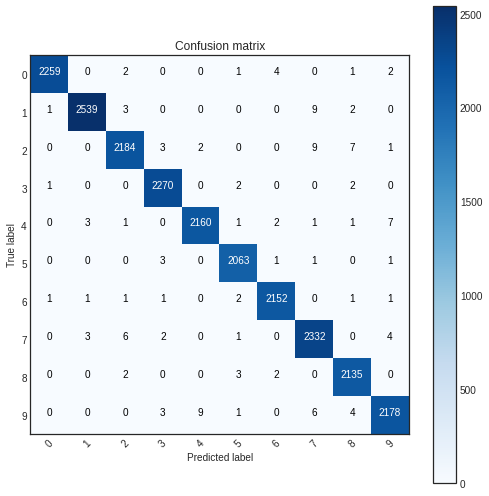

In [ ]:
plot_confusion_matrix(confusion_mtx, classes=range(10))

## Create Predict model

In [ ]:
classifier = classifer_arc(INPUT_SIZE, num_classes, '/content/HwR_ver3_09_10.h5')
classifier.summary()

/usr/local/lib/python3.7/dist-packages/keras/engine/base_layer.py:2223: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  warnings.warn('`layer.add_variable` is deprecated and '


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
model (Functional)           (None, 512)               1051488   
Total params: 1,051,488
Trainable params: 1,049,984
Non-trainable params: 1,504
_________________________________________________________________


In [ ]:
X_database = classifier.predict(X_preprocess)

In [ ]:
X_test_embeb = classifier.predict(X_test_preprocessed)

In [ ]:
!pip install faiss-cpu --no-cache

     |████████████████████████████████| 8.4 MB 4.0 MB/s 


In [ ]:
import faiss

In [ ]:
index = faiss.IndexFlatL2(512)

In [ ]:
index.add(X_database)

In [ ]:
def _most_similarity(vec, labels):
  dst, neig = index.search(vec, 5)
  label = labels[neig[0][0]]
  return label

In [ ]:
results = []
for vec in X_test_embeb:
  vec = vec.reshape(1, -1)
  y_pred = _most_similarity(vec, Y)
  results.append(y_pred)

# Submit

In [ ]:

result = pd.Series(results, name="Label")
submission = pd.concat([pd.Series(range(1,28001),name = "ImageId"), result],axis = 1)
submission.to_csv("submission.csv",index=False)